In [1]:
# Imports and user-configurable settings

import os
import gc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_fscore_support, accuracy_score

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

ROOT_DIR = "/content/drive/MyDrive/AutismData"
TRAIN_DIR = os.path.join(ROOT_DIR, "train")
TEST_DIR  = os.path.join(ROOT_DIR, "test")   # separate held-out test set
K = 5
BATCH_SIZE = 32
IMG_SIZE = (299, 299)
BASE_EPOCHS = 10
FT_EPOCHS = 5
LR_BASE = 1e-3
LR_FINE = 1e-5
UNFREEZE_LAST_N = 200      # reduce number of layers to unfreeze if OOM
RANDOM_STATE = 42
AUTOTUNE = tf.data.AUTOTUNE


In [2]:
# Mount Google Drive (optional). If you store the data in Drive, uncomment and run.
# After mounting, update ROOT_DIR to point to the folder that contains 'train' and 'test' subfolders.

from google.colab import drive
drive.mount('/content/drive')

# Example: if your data is in MyDrive/AutismData, set:
#ROOT_DIR = "/content/drive/MyDrive/AutismData"

# If you're not using Drive, leave ROOT_DIR as the local folder (you can upload files to /content/AutismData).



Mounted at /content/drive


In [3]:
print("Current ROOT_DIR =", ROOT_DIR)
print("Expected subfolders: train/ and test/ inside ROOT_DIR.")

Current ROOT_DIR = /content/drive/MyDrive/AutismData
Expected subfolders: train/ and test/ inside ROOT_DIR.


In [4]:
# Helper function to build a dataframe listing images and labels
def build_dataframe_from_folder(folder):
    rows = []
    if not os.path.exists(folder):
        raise ValueError(f"Folder not found: {folder}")
    classes = sorted([d for d in os.listdir(folder) if os.path.isdir(os.path.join(folder, d))])
    if len(classes) == 0:
        raise ValueError(f"No class subfolders found in {folder}")
    for cls in classes:
        cls_dir = os.path.join(folder, cls)
        for fname in os.listdir(cls_dir):
            if fname.lower().endswith((".png", ".jpg", ".jpeg", ".bmp", ".gif")):
                rows.append({
                    "image_path": os.path.join(cls_dir, fname),
                    "labels": cls
                })
    df = pd.DataFrame(rows)
    if df.empty:
        raise ValueError(f"No images found under {folder}")
    df = df.sample(frac=1, random_state=RANDOM_STATE).reset_index(drop=True)
    return df

# Build train and test DataFrames (will raise helpful errors if folders are missing)
train_df = build_dataframe_from_folder(TRAIN_DIR)
test_df  = build_dataframe_from_folder(TEST_DIR)

label_names = sorted(train_df['labels'].unique())
print("Detected classes:", label_names)
is_binary = (len(label_names) == 2)

# For later mapping (useful for metrics)
label_to_idx = {lab: i for i, lab in enumerate(label_names)}
idx_to_label = {i: lab for lab, i in label_to_idx.items()}


Detected classes: ['Autistic', 'Non_Autistic']


In [5]:
# Setup cross-validation objects and storage for results

skf = StratifiedKFold(n_splits=K, shuffle=True, random_state=RANDOM_STATE)

fold = 0
val_accs = []
val_losses = []
histories = []    # store history objects (we'll store the 'history' dict for each fold)
ckpt_paths = []


In [6]:
# Training loop: K-fold CV. This cell runs the training for all folds.
# We print model.summary() for the first fold so you can inspect the architecture.

for train_idx, val_idx in skf.split(np.zeros(len(train_df)), train_df['labels'].values):
    fold += 1
    print(f"\n--- Fold {fold}/{K} ---")
    df_train_fold = train_df.iloc[train_idx].reset_index(drop=True)
    df_val_fold   = train_df.iloc[val_idx].reset_index(drop=True)

    # Data augmentation & preprocessing
    train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                                       horizontal_flip=True,
                                       rotation_range=20,
                                       width_shift_range=0.1,
                                       height_shift_range=0.1,
                                       zoom_range=0.1)
    val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

    train_gen = train_datagen.flow_from_dataframe(
        dataframe=df_train_fold,
        x_col="image_path",
        y_col="labels",
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode="binary" if is_binary else "categorical",
        shuffle=True,
    )

    val_gen = val_datagen.flow_from_dataframe(
        dataframe=df_val_fold,
        x_col="image_path",
        y_col="labels",
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode="binary" if is_binary else "categorical",
        shuffle=False,
    )

    # Build model
    tf.keras.backend.clear_session()   # free memory between folds
    base_model = InceptionV3(include_top=False, weights="imagenet",
                             input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
    base_model.trainable = False

    x = layers.GlobalAveragePooling2D()(base_model.output)
    x = layers.Dense(512, activation="relu")(x)
    x = layers.Dropout(0.5)(x)
    if is_binary:
        output = layers.Dense(1, activation="sigmoid")(x)
        loss = "binary_crossentropy"
        metrics = ["accuracy"]
    else:
        output = layers.Dense(len(label_names), activation="softmax")(x)
        loss = "categorical_crossentropy"
        metrics = ["accuracy"]

    model = models.Model(inputs=base_model.input, outputs=output)
    model.compile(optimizer=Adam(learning_rate=LR_BASE),
                  loss=loss,
                  metrics=metrics)

    # Show model summary for the first fold (so you can inspect architecture)
    if fold == 1:
        print("\n--- Model summary (fold 1) ---")
        model.summary()

    # Callbacks & checkpoint (save to current working directory or Drive if ROOT_DIR points to Drive)
    ckpt_path = os.path.join(".", f"best_model_fold_{fold}.h5")
    ckpt_paths.append(ckpt_path)
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True, verbose=1),
        ModelCheckpoint(ckpt_path, monitor='val_loss', save_best_only=True, verbose=1)
    ]

    try:
        history = model.fit(
            train_gen,
            validation_data=val_gen,
            epochs=BASE_EPOCHS,
            callbacks=callbacks,
            verbose=1
        )
    except tf.errors.ResourceExhaustedError as e:
        print("ResourceExhaustedError during base training (OOM).")
        print("Suggestions: reduce BATCH_SIZE, reduce IMG_SIZE, set FT_EPOCHS=0 or lower UNFREEZE_LAST_N.")
        raise e

    # optional fine-tuning
    if FT_EPOCHS > 0:
        # Unfreeze last UNFREEZE_LAST_N layers (but keep the earlier ones frozen)
        for layer in base_model.layers[-UNFREEZE_LAST_N:]:
            layer.trainable = True
        model.compile(optimizer=Adam(learning_rate=LR_FINE),
                      loss=loss,
                      metrics=metrics)
        print(f"Fine-tuning last {UNFREEZE_LAST_N} layers for {FT_EPOCHS} epochs with lr={LR_FINE}")
        try:
            history_finetune = model.fit(
                train_gen,
                validation_data=val_gen,
                epochs=FT_EPOCHS,
                callbacks=callbacks,
                verbose=1
            )
            # If fine-tune ran, you may want to merge histories; here we keep the initial history object
        except tf.errors.ResourceExhaustedError as e:
            print("ResourceExhaustedError during fine-tuning (OOM).")
            print("Skipping fine-tune for this fold. Consider lowering UNFREEZE_LAST_N or FT_EPOCHS or reducing batch size.")
            # Continue to next steps without re-raising to allow CV to continue.

    # Evaluate on val set (best weights are restored via EarlyStopping)
    val_eval = model.evaluate(val_gen, verbose=0)
    val_loss, val_acc = val_eval[0], val_eval[1]
    print(f"Fold {fold} best-val-loss: {val_loss:.4f}, best-val-acc: {val_acc:.4f}")
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    histories.append(history.history)

    # Clean up to reduce memory before next fold
    del model, base_model, train_gen, val_gen, train_datagen, val_datagen
    tf.keras.backend.clear_session()
    gc.collect()



--- Fold 1/5 ---
Found 1853 validated image filenames belonging to 2 classes.
Found 464 validated image filenames belonging to 2 classes.
87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

--- Model summary (fold 1) ---


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 299, 299,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 149, 149,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 149, 149,  │         96 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 149, 149,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 147, 147,  │      9,216 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 147, 147,  │         96 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 147, 147,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 147, 147,  │     18,432 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 147, 147,  │        192 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 147, 147,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 73, 73,    │          0 │ activation_2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 73, 73,    │      5,120 │ max_pooling2d[0]… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 73, 73,    │        240 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 73, 73,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 71, 71,    │    138,240 │ activation_3[0][… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 71, 71,    │        576 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 71, 71,    │          0 │ batch_normalizat

 Total params: 22,852,385 (87.17 MB)

 Trainable params: 1,049,601 (4.00 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.5507 - loss: 1.0403
Epoch 1: val_loss improved from inf to 0.55543, saving model to ./best_model_fold_1.h5


58/58 ━━━━━━━━━━━━━━━━━━━━ 545s 9s/step - accuracy: 0.5514 - loss: 1.0363 - val_accuracy: 0.7177 - val_loss: 0.5554
Epoch 2/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 810ms/step - accuracy: 0.6919 - loss: 0.5710
Epoch 2: val_loss improved from 0.55543 to 0.53365, saving model to ./best_model_fold_1.h5


58/58 ━━━━━━━━━━━━━━━━━━━━ 51s 886ms/step - accuracy: 0.6920 - loss: 0.5711 - val_accuracy: 0.7392 - val_loss: 0.5336
Epoch 3/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 794ms/step - accuracy: 0.7186 - loss: 0.5424
Epoch 3: val_loss improved from 0.53365 to 0.52427, saving model to ./best_model_fold_1.h5


58/58 ━━━━━━━━━━━━━━━━━━━━ 50s 864ms/step - accuracy: 0.7185 - loss: 0.5428 - val_accuracy: 0.7284 - val_loss: 0.5243
Epoch 4/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 812ms/step - accuracy: 0.7093 - loss: 0.5544
Epoch 4: val_loss improved from 0.52427 to 0.51632, saving model to ./best_model_fold_1.h5


58/58 ━━━━━━━━━━━━━━━━━━━━ 51s 878ms/step - accuracy: 0.7095 - loss: 0.5543 - val_accuracy: 0.7392 - val_loss: 0.5163
Epoch 5/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 813ms/step - accuracy: 0.7641 - loss: 0.5044
Epoch 5: val_loss improved from 0.51632 to 0.51169, saving model to ./best_model_fold_1.h5


58/58 ━━━━━━━━━━━━━━━━━━━━ 52s 878ms/step - accuracy: 0.7639 - loss: 0.5046 - val_accuracy: 0.7478 - val_loss: 0.5117
Epoch 6/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 802ms/step - accuracy: 0.7456 - loss: 0.5195
Epoch 6: val_loss improved from 0.51169 to 0.48630, saving model to ./best_model_fold_1.h5


58/58 ━━━━━━━━━━━━━━━━━━━━ 81s 877ms/step - accuracy: 0.7458 - loss: 0.5193 - val_accuracy: 0.7500 - val_loss: 0.4863
Epoch 7/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 806ms/step - accuracy: 0.7533 - loss: 0.5241
Epoch 7: val_loss improved from 0.48630 to 0.48595, saving model to ./best_model_fold_1.h5


58/58 ━━━━━━━━━━━━━━━━━━━━ 51s 872ms/step - accuracy: 0.7533 - loss: 0.5238 - val_accuracy: 0.7651 - val_loss: 0.4860
Epoch 8/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 805ms/step - accuracy: 0.7715 - loss: 0.4869
Epoch 8: val_loss did not improve from 0.48595
58/58 ━━━━━━━━━━━━━━━━━━━━ 50s 856ms/step - accuracy: 0.7715 - loss: 0.4869 - val_accuracy: 0.7069 - val_loss: 0.5481
Epoch 9/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 824ms/step - accuracy: 0.7089 - loss: 0.5952
Epoch 9: val_loss did not improve from 0.48595
58/58 ━━━━━━━━━━━━━━━━━━━━ 51s 875ms/step - accuracy: 0.7093 - loss: 0.5944 - val_accuracy: 0.7543 - val_loss: 0.4953
Epoch 10/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 820ms/step - accuracy: 0.7607 - loss: 0.4832
Epoch 10: val_loss did not improve from 0.48595
58/58 ━━━━━━━━━━━━━━━━━━━━ 51s 871ms/step - accuracy: 0.7608 - loss: 0.4832 - val_accuracy: 0.7457 - val_loss: 0.5050
Restoring model weights from the end of the best epoch: 7.
Fine-tuning last 200 layers for 5 epochs with lr=1e-05
Epoch 1/5
58/

58/58 ━━━━━━━━━━━━━━━━━━━━ 84s 965ms/step - accuracy: 0.7715 - loss: 0.4489 - val_accuracy: 0.7845 - val_loss: 0.4713
Epoch 4/5
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 881ms/step - accuracy: 0.8215 - loss: 0.4064
Epoch 4: val_loss improved from 0.47132 to 0.44544, saving model to ./best_model_fold_1.h5


58/58 ━━━━━━━━━━━━━━━━━━━━ 55s 951ms/step - accuracy: 0.8215 - loss: 0.4065 - val_accuracy: 0.8060 - val_loss: 0.4454
Epoch 5/5
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 876ms/step - accuracy: 0.8416 - loss: 0.3888
Epoch 5: val_loss improved from 0.44544 to 0.44134, saving model to ./best_model_fold_1.h5


58/58 ━━━━━━━━━━━━━━━━━━━━ 55s 944ms/step - accuracy: 0.8413 - loss: 0.3889 - val_accuracy: 0.8017 - val_loss: 0.4413
Restoring model weights from the end of the best epoch: 5.
Fold 1 best-val-loss: 0.4413, best-val-acc: 0.8017

--- Fold 2/5 ---
Found 1853 validated image filenames belonging to 2 classes.
Found 464 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 896ms/step - accuracy: 0.5705 - loss: 0.9155
Epoch 1: val_loss improved from inf to 0.57193, saving model to ./best_model_fold_2.h5


58/58 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - accuracy: 0.5715 - loss: 0.9128 - val_accuracy: 0.7047 - val_loss: 0.5719
Epoch 2/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 817ms/step - accuracy: 0.6902 - loss: 0.5849
Epoch 2: val_loss improved from 0.57193 to 0.51777, saving model to ./best_model_fold_2.h5


58/58 ━━━━━━━━━━━━━━━━━━━━ 51s 881ms/step - accuracy: 0.6904 - loss: 0.5847 - val_accuracy: 0.7328 - val_loss: 0.5178
Epoch 3/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 792ms/step - accuracy: 0.7294 - loss: 0.5499
Epoch 3: val_loss improved from 0.51777 to 0.49984, saving model to ./best_model_fold_2.h5


58/58 ━━━━━━━━━━━━━━━━━━━━ 50s 867ms/step - accuracy: 0.7294 - loss: 0.5498 - val_accuracy: 0.7500 - val_loss: 0.4998
Epoch 4/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 810ms/step - accuracy: 0.7290 - loss: 0.5387
Epoch 4: val_loss improved from 0.49984 to 0.49242, saving model to ./best_model_fold_2.h5


58/58 ━━━━━━━━━━━━━━━━━━━━ 53s 913ms/step - accuracy: 0.7291 - loss: 0.5386 - val_accuracy: 0.7694 - val_loss: 0.4924
Epoch 5/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 798ms/step - accuracy: 0.7506 - loss: 0.5008
Epoch 5: val_loss did not improve from 0.49242
58/58 ━━━━━━━━━━━━━━━━━━━━ 49s 851ms/step - accuracy: 0.7504 - loss: 0.5010 - val_accuracy: 0.7457 - val_loss: 0.5103
Epoch 6/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 805ms/step - accuracy: 0.7823 - loss: 0.4797
Epoch 6: val_loss improved from 0.49242 to 0.47803, saving model to ./best_model_fold_2.h5


58/58 ━━━━━━━━━━━━━━━━━━━━ 51s 867ms/step - accuracy: 0.7819 - loss: 0.4800 - val_accuracy: 0.7866 - val_loss: 0.4780
Epoch 7/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 814ms/step - accuracy: 0.7286 - loss: 0.5322
Epoch 7: val_loss improved from 0.47803 to 0.46823, saving model to ./best_model_fold_2.h5


58/58 ━━━━━━━━━━━━━━━━━━━━ 51s 878ms/step - accuracy: 0.7286 - loss: 0.5322 - val_accuracy: 0.7651 - val_loss: 0.4682
Epoch 8/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 818ms/step - accuracy: 0.7678 - loss: 0.5045
Epoch 8: val_loss improved from 0.46823 to 0.46380, saving model to ./best_model_fold_2.h5


58/58 ━━━━━━━━━━━━━━━━━━━━ 52s 883ms/step - accuracy: 0.7678 - loss: 0.5042 - val_accuracy: 0.7651 - val_loss: 0.4638
Epoch 9/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 832ms/step - accuracy: 0.7778 - loss: 0.4813
Epoch 9: val_loss did not improve from 0.46380
58/58 ━━━━━━━━━━━━━━━━━━━━ 51s 881ms/step - accuracy: 0.7777 - loss: 0.4813 - val_accuracy: 0.7565 - val_loss: 0.4971
Epoch 10/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 795ms/step - accuracy: 0.7547 - loss: 0.4913
Epoch 10: val_loss did not improve from 0.46380
58/58 ━━━━━━━━━━━━━━━━━━━━ 49s 853ms/step - accuracy: 0.7546 - loss: 0.4916 - val_accuracy: 0.7435 - val_loss: 0.5268
Restoring model weights from the end of the best epoch: 8.
Fine-tuning last 200 layers for 5 epochs with lr=1e-05
Epoch 1/5
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5819 - loss: 0.7607
Epoch 1: val_loss did not improve from 0.46380
58/58 ━━━━━━━━━━━━━━━━━━━━ 128s 1s/step - accuracy: 0.5827 - loss: 0.7595 - val_accuracy: 0.7392 - val_loss: 0.5735
Epoch 2/5
58/58 ━━━

58/58 ━━━━━━━━━━━━━━━━━━━━ 83s 944ms/step - accuracy: 0.8058 - loss: 0.4216 - val_accuracy: 0.7845 - val_loss: 0.4370
Epoch 5/5
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 867ms/step - accuracy: 0.8134 - loss: 0.3992
Epoch 5: val_loss improved from 0.43697 to 0.41682, saving model to ./best_model_fold_2.h5


58/58 ━━━━━━━━━━━━━━━━━━━━ 55s 939ms/step - accuracy: 0.8135 - loss: 0.3990 - val_accuracy: 0.7888 - val_loss: 0.4168
Restoring model weights from the end of the best epoch: 5.
Fold 2 best-val-loss: 0.4168, best-val-acc: 0.7888

--- Fold 3/5 ---
Found 1854 validated image filenames belonging to 2 classes.
Found 463 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 1000ms/step - accuracy: 0.5766 - loss: 0.8138
Epoch 1: val_loss improved from inf to 0.61192, saving model to ./best_model_fold_3.h5


58/58 ━━━━━━━━━━━━━━━━━━━━ 90s 1s/step - accuracy: 0.5775 - loss: 0.8118 - val_accuracy: 0.6479 - val_loss: 0.6119
Epoch 2/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 792ms/step - accuracy: 0.7050 - loss: 0.5718
Epoch 2: val_loss improved from 0.61192 to 0.54228, saving model to ./best_model_fold_3.h5


58/58 ━━━━━━━━━━━━━━━━━━━━ 51s 871ms/step - accuracy: 0.7052 - loss: 0.5716 - val_accuracy: 0.7106 - val_loss: 0.5423
Epoch 3/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 796ms/step - accuracy: 0.7156 - loss: 0.5538
Epoch 3: val_loss improved from 0.54228 to 0.51649, saving model to ./best_model_fold_3.h5


58/58 ━━━━━━━━━━━━━━━━━━━━ 52s 899ms/step - accuracy: 0.7157 - loss: 0.5538 - val_accuracy: 0.7538 - val_loss: 0.5165
Epoch 4/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 790ms/step - accuracy: 0.7158 - loss: 0.5320
Epoch 4: val_loss did not improve from 0.51649
58/58 ━━━━━━━━━━━━━━━━━━━━ 49s 842ms/step - accuracy: 0.7159 - loss: 0.5319 - val_accuracy: 0.7257 - val_loss: 0.5231
Epoch 5/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 809ms/step - accuracy: 0.7228 - loss: 0.5585
Epoch 5: val_loss improved from 0.51649 to 0.48607, saving model to ./best_model_fold_3.h5


58/58 ━━━━━━━━━━━━━━━━━━━━ 51s 874ms/step - accuracy: 0.7230 - loss: 0.5581 - val_accuracy: 0.7883 - val_loss: 0.4861
Epoch 6/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 812ms/step - accuracy: 0.7453 - loss: 0.5063
Epoch 6: val_loss improved from 0.48607 to 0.48365, saving model to ./best_model_fold_3.h5


58/58 ━━━━━━━━━━━━━━━━━━━━ 51s 879ms/step - accuracy: 0.7455 - loss: 0.5060 - val_accuracy: 0.7905 - val_loss: 0.4837
Epoch 7/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 821ms/step - accuracy: 0.7545 - loss: 0.5185
Epoch 7: val_loss did not improve from 0.48365
58/58 ━━━━━━━━━━━━━━━━━━━━ 51s 875ms/step - accuracy: 0.7545 - loss: 0.5181 - val_accuracy: 0.7732 - val_loss: 0.4955
Epoch 8/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 790ms/step - accuracy: 0.7460 - loss: 0.5099
Epoch 8: val_loss did not improve from 0.48365
58/58 ━━━━━━━━━━━━━━━━━━━━ 49s 850ms/step - accuracy: 0.7459 - loss: 0.5100 - val_accuracy: 0.7473 - val_loss: 0.5025
Epoch 9/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 796ms/step - accuracy: 0.7576 - loss: 0.4799
Epoch 9: val_loss did not improve from 0.48365
58/58 ━━━━━━━━━━━━━━━━━━━━ 49s 846ms/step - accuracy: 0.7576 - loss: 0.4800 - val_accuracy: 0.7387 - val_loss: 0.5057
Epoch 10/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 810ms/step - accuracy: 0.7684 - loss: 0.4816
Epoch 10: val_loss did not improve from 0.

58/58 ━━━━━━━━━━━━━━━━━━━━ 55s 947ms/step - accuracy: 0.8119 - loss: 0.4091 - val_accuracy: 0.7797 - val_loss: 0.4633
Epoch 5/5
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 887ms/step - accuracy: 0.8336 - loss: 0.3710
Epoch 5: val_loss improved from 0.46328 to 0.45089, saving model to ./best_model_fold_3.h5


58/58 ━━━━━━━━━━━━━━━━━━━━ 83s 960ms/step - accuracy: 0.8335 - loss: 0.3713 - val_accuracy: 0.7927 - val_loss: 0.4509
Restoring model weights from the end of the best epoch: 5.
Fold 3 best-val-loss: 0.4509, best-val-acc: 0.7927

--- Fold 4/5 ---
Found 1854 validated image filenames belonging to 2 classes.
Found 463 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 906ms/step - accuracy: 0.6184 - loss: 0.8187
Epoch 1: val_loss improved from inf to 0.55300, saving model to ./best_model_fold_4.h5


58/58 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - accuracy: 0.6190 - loss: 0.8167 - val_accuracy: 0.7257 - val_loss: 0.5530
Epoch 2/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 792ms/step - accuracy: 0.7130 - loss: 0.5517
Epoch 2: val_loss did not improve from 0.55300
58/58 ━━━━━━━━━━━━━━━━━━━━ 57s 846ms/step - accuracy: 0.7128 - loss: 0.5520 - val_accuracy: 0.7149 - val_loss: 0.5538
Epoch 3/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 805ms/step - accuracy: 0.7339 - loss: 0.5348
Epoch 3: val_loss did not improve from 0.55300
58/58 ━━━━━━━━━━━━━━━━━━━━ 50s 853ms/step - accuracy: 0.7337 - loss: 0.5351 - val_accuracy: 0.6674 - val_loss: 0.6065
Epoch 4/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 837ms/step - accuracy: 0.7259 - loss: 0.5293
Epoch 4: val_loss improved from 0.55300 to 0.54459, saving model to ./best_model_fold_4.h5


58/58 ━━━━━━━━━━━━━━━━━━━━ 52s 900ms/step - accuracy: 0.7258 - loss: 0.5294 - val_accuracy: 0.7192 - val_loss: 0.5446
Epoch 5/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 814ms/step - accuracy: 0.7384 - loss: 0.5284
Epoch 5: val_loss improved from 0.54459 to 0.52833, saving model to ./best_model_fold_4.h5


58/58 ━━━━━━━━━━━━━━━━━━━━ 51s 875ms/step - accuracy: 0.7385 - loss: 0.5281 - val_accuracy: 0.7387 - val_loss: 0.5283
Epoch 6/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 812ms/step - accuracy: 0.7410 - loss: 0.5122
Epoch 6: val_loss improved from 0.52833 to 0.52316, saving model to ./best_model_fold_4.h5


58/58 ━━━━━━━━━━━━━━━━━━━━ 51s 875ms/step - accuracy: 0.7412 - loss: 0.5122 - val_accuracy: 0.7473 - val_loss: 0.5232
Epoch 7/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 814ms/step - accuracy: 0.7481 - loss: 0.5076
Epoch 7: val_loss improved from 0.52316 to 0.52034, saving model to ./best_model_fold_4.h5


58/58 ━━━━━━━━━━━━━━━━━━━━ 83s 875ms/step - accuracy: 0.7482 - loss: 0.5073 - val_accuracy: 0.7451 - val_loss: 0.5203
Epoch 8/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 831ms/step - accuracy: 0.7724 - loss: 0.4738
Epoch 8: val_loss did not improve from 0.52034
58/58 ━━━━━━━━━━━━━━━━━━━━ 51s 879ms/step - accuracy: 0.7722 - loss: 0.4742 - val_accuracy: 0.7343 - val_loss: 0.5255
Epoch 9/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 815ms/step - accuracy: 0.7700 - loss: 0.4787
Epoch 9: val_loss improved from 0.52034 to 0.51011, saving model to ./best_model_fold_4.h5


58/58 ━━━━━━━━━━━━━━━━━━━━ 51s 877ms/step - accuracy: 0.7700 - loss: 0.4788 - val_accuracy: 0.7559 - val_loss: 0.5101
Epoch 10/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 796ms/step - accuracy: 0.7633 - loss: 0.4898
Epoch 10: val_loss did not improve from 0.51011
58/58 ━━━━━━━━━━━━━━━━━━━━ 51s 886ms/step - accuracy: 0.7634 - loss: 0.4897 - val_accuracy: 0.7322 - val_loss: 0.5501
Restoring model weights from the end of the best epoch: 9.
Fine-tuning last 200 layers for 5 epochs with lr=1e-05
Epoch 1/5
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5792 - loss: 0.7921
Epoch 1: val_loss did not improve from 0.51011
58/58 ━━━━━━━━━━━━━━━━━━━━ 131s 1s/step - accuracy: 0.5800 - loss: 0.7906 - val_accuracy: 0.7451 - val_loss: 0.5633
Epoch 2/5
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 866ms/step - accuracy: 0.7452 - loss: 0.5272
Epoch 2: val_loss did not improve from 0.51011
58/58 ━━━━━━━━━━━━━━━━━━━━ 53s 918ms/step - accuracy: 0.7455 - loss: 0.5267 - val_accuracy: 0.7257 - val_loss: 0.5793
Epoch 3/5
58/58 ━━━━

58/58 ━━━━━━━━━━━━━━━━━━━━ 55s 941ms/step - accuracy: 0.7939 - loss: 0.4477 - val_accuracy: 0.7603 - val_loss: 0.4981
Epoch 4/5
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 873ms/step - accuracy: 0.8206 - loss: 0.3888
Epoch 4: val_loss improved from 0.49807 to 0.48296, saving model to ./best_model_fold_4.h5


58/58 ━━━━━━━━━━━━━━━━━━━━ 56s 954ms/step - accuracy: 0.8206 - loss: 0.3889 - val_accuracy: 0.7689 - val_loss: 0.4830
Epoch 5/5
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 876ms/step - accuracy: 0.8429 - loss: 0.3727
Epoch 5: val_loss improved from 0.48296 to 0.44618, saving model to ./best_model_fold_4.h5


58/58 ━━━━━━━━━━━━━━━━━━━━ 55s 950ms/step - accuracy: 0.8429 - loss: 0.3728 - val_accuracy: 0.7862 - val_loss: 0.4462
Restoring model weights from the end of the best epoch: 5.
Fold 4 best-val-loss: 0.4462, best-val-acc: 0.7862

--- Fold 5/5 ---
Found 1854 validated image filenames belonging to 2 classes.
Found 463 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 896ms/step - accuracy: 0.5614 - loss: 1.0280
Epoch 1: val_loss improved from inf to 0.56029, saving model to ./best_model_fold_5.h5


58/58 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - accuracy: 0.5623 - loss: 1.0235 - val_accuracy: 0.7171 - val_loss: 0.5603
Epoch 2/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 819ms/step - accuracy: 0.6830 - loss: 0.5898
Epoch 2: val_loss improved from 0.56029 to 0.54469, saving model to ./best_model_fold_5.h5


58/58 ━━━━━━━━━━━━━━━━━━━━ 51s 884ms/step - accuracy: 0.6831 - loss: 0.5898 - val_accuracy: 0.7365 - val_loss: 0.5447
Epoch 3/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 843ms/step - accuracy: 0.7013 - loss: 0.5551
Epoch 3: val_loss improved from 0.54469 to 0.50579, saving model to ./best_model_fold_5.h5


58/58 ━━━━━━━━━━━━━━━━━━━━ 53s 909ms/step - accuracy: 0.7015 - loss: 0.5550 - val_accuracy: 0.7689 - val_loss: 0.5058
Epoch 4/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 797ms/step - accuracy: 0.7197 - loss: 0.5518
Epoch 4: val_loss improved from 0.50579 to 0.50230, saving model to ./best_model_fold_5.h5


58/58 ━━━━━━━━━━━━━━━━━━━━ 50s 867ms/step - accuracy: 0.7201 - loss: 0.5515 - val_accuracy: 0.7430 - val_loss: 0.5023
Epoch 5/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 792ms/step - accuracy: 0.7200 - loss: 0.5370
Epoch 5: val_loss improved from 0.50230 to 0.49567, saving model to ./best_model_fold_5.h5


58/58 ━━━━━━━━━━━━━━━━━━━━ 50s 860ms/step - accuracy: 0.7202 - loss: 0.5368 - val_accuracy: 0.7711 - val_loss: 0.4957
Epoch 6/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 792ms/step - accuracy: 0.7265 - loss: 0.5408
Epoch 6: val_loss improved from 0.49567 to 0.48409, saving model to ./best_model_fold_5.h5


58/58 ━━━━━━━━━━━━━━━━━━━━ 50s 854ms/step - accuracy: 0.7267 - loss: 0.5406 - val_accuracy: 0.7754 - val_loss: 0.4841
Epoch 7/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 824ms/step - accuracy: 0.7536 - loss: 0.4936
Epoch 7: val_loss improved from 0.48409 to 0.48091, saving model to ./best_model_fold_5.h5


58/58 ━━━━━━━━━━━━━━━━━━━━ 52s 889ms/step - accuracy: 0.7535 - loss: 0.4938 - val_accuracy: 0.7797 - val_loss: 0.4809
Epoch 8/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 823ms/step - accuracy: 0.7622 - loss: 0.5082
Epoch 8: val_loss improved from 0.48091 to 0.47050, saving model to ./best_model_fold_5.h5


58/58 ━━━━━━━━━━━━━━━━━━━━ 51s 885ms/step - accuracy: 0.7621 - loss: 0.5081 - val_accuracy: 0.7732 - val_loss: 0.4705
Epoch 9/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 850ms/step - accuracy: 0.7613 - loss: 0.4933
Epoch 9: val_loss did not improve from 0.47050
58/58 ━━━━━━━━━━━━━━━━━━━━ 52s 902ms/step - accuracy: 0.7611 - loss: 0.4934 - val_accuracy: 0.7667 - val_loss: 0.4727
Epoch 10/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 812ms/step - accuracy: 0.7596 - loss: 0.4878
Epoch 10: val_loss did not improve from 0.47050
58/58 ━━━━━━━━━━━━━━━━━━━━ 50s 871ms/step - accuracy: 0.7596 - loss: 0.4880 - val_accuracy: 0.7819 - val_loss: 0.4707
Restoring model weights from the end of the best epoch: 8.
Fine-tuning last 200 layers for 5 epochs with lr=1e-05
Epoch 1/5
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5928 - loss: 0.7042
Epoch 1: val_loss did not improve from 0.47050
58/58 ━━━━━━━━━━━━━━━━━━━━ 130s 1s/step - accuracy: 0.5936 - loss: 0.7032 - val_accuracy: 0.7430 - val_loss: 0.5482
Epoch 2/5
58/58 ━━━

58/58 ━━━━━━━━━━━━━━━━━━━━ 56s 959ms/step - accuracy: 0.7996 - loss: 0.4447 - val_accuracy: 0.8056 - val_loss: 0.4359
Epoch 4/5
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 876ms/step - accuracy: 0.7972 - loss: 0.4279
Epoch 4: val_loss improved from 0.43594 to 0.41727, saving model to ./best_model_fold_5.h5


58/58 ━━━━━━━━━━━━━━━━━━━━ 63s 1s/step - accuracy: 0.7974 - loss: 0.4277 - val_accuracy: 0.8099 - val_loss: 0.4173
Epoch 5/5
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 855ms/step - accuracy: 0.8306 - loss: 0.3892
Epoch 5: val_loss improved from 0.41727 to 0.40222, saving model to ./best_model_fold_5.h5


58/58 ━━━━━━━━━━━━━━━━━━━━ 60s 1s/step - accuracy: 0.8308 - loss: 0.3892 - val_accuracy: 0.8251 - val_loss: 0.4022
Restoring model weights from the end of the best epoch: 5.
Fold 5 best-val-loss: 0.4022, best-val-acc: 0.8251



=== Cross-validation results ===
Validation accuracy per fold: [0.8017 0.7888 0.7927 0.7862 0.8251]
Mean val accuracy: 0.7989 ± 0.0141
Validation loss per fold: [0.4413 0.4168 0.4509 0.4462 0.4022]
Mean val loss: 0.4315 ± 0.0188

Best fold: 5 (index 4) with val_loss=0.4022


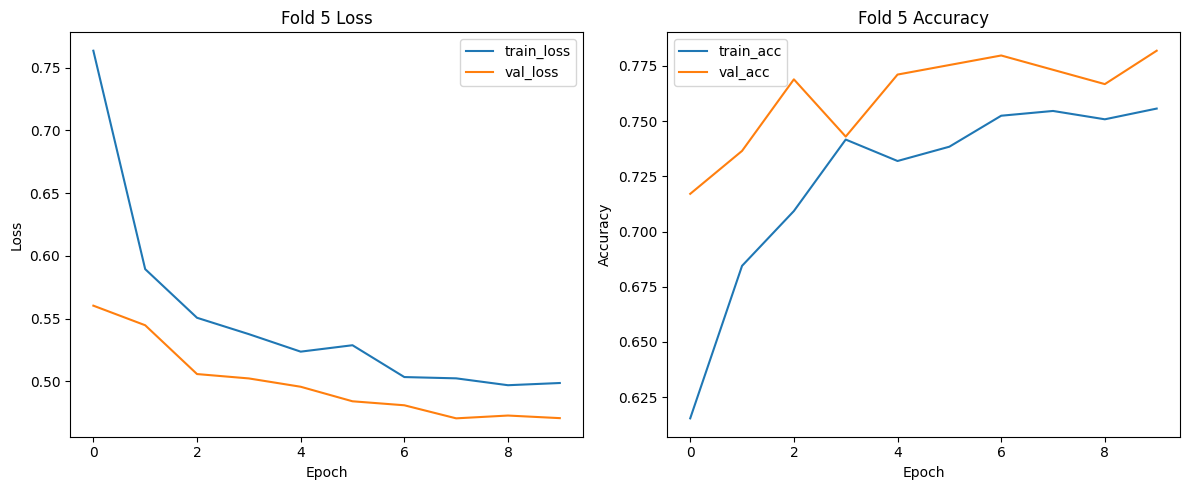

In [9]:
# Summarize cross-validation results and pick best fold

print("\n=== Cross-validation results ===")
print(f"Validation accuracy per fold: {np.round(val_accs, 4)}")
print(f"Mean val accuracy: {np.mean(val_accs):.4f} ± {np.std(val_accs):.4f}")
print(f"Validation loss per fold: {np.round(val_losses, 4)}")
print(f"Mean val loss: {np.mean(val_losses):.4f} ± {np.std(val_losses):.4f}")

# Choose best fold (lowest val_loss)
best_fold_idx = int(np.argmin(val_losses))  # 0-based
best_fold = best_fold_idx + 1
print(f"\nBest fold: {best_fold} (index {best_fold_idx}) with val_loss={val_losses[best_fold_idx]:.4f}")

# Plot train vs val curves for the best fold (if history exists)
best_hist = histories[best_fold_idx]
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(best_hist.get('loss', []), label='train_loss')
plt.plot(best_hist.get('val_loss', []), label='val_loss')
plt.title(f'Fold {best_fold} Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(best_hist.get('accuracy', []), label='train_acc')
plt.plot(best_hist.get('val_accuracy', []), label='val_acc')
plt.title(f'Fold {best_fold} Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()


Loading best model from: ./best_model_fold_5.h5



--- Loaded model summary ---


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 299, 299,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 149, 149,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 149, 149,  │         96 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 149, 149,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 147, 147,  │      9,216 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 147, 147,  │         96 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 147, 147,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 147, 147,  │     18,432 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 147, 147,  │        192 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 147, 147,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 73, 73,    │          0 │ activation_2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 73, 73,    │      5,120 │ max_pooling2d[0]… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 73, 73,    │        240 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 73, 73,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 71, 71,    │    138,240 │ activation_3[0][… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 71, 71,    │        576 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 71, 71,    │          0 │ batch_normalizat

 Total params: 22,852,387 (87.17 MB)

 Trainable params: 20,249,473 (77.25 MB)

 Non-trainable params: 2,602,912 (9.93 MB)

 Optimizer params: 2 (12.00 B)

Found 580 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


19/19 ━━━━━━━━━━━━━━━━━━━━ 16s 445ms/step - accuracy: 0.7960 - loss: 0.4574
Test loss/acc (best fold model): [0.4446885287761688, 0.798275887966156]
19/19 ━━━━━━━━━━━━━━━━━━━━ 17s 559ms/step
Confusion matrix (rows=true, cols=pred):
 [[227  62]
 [ 55 236]]


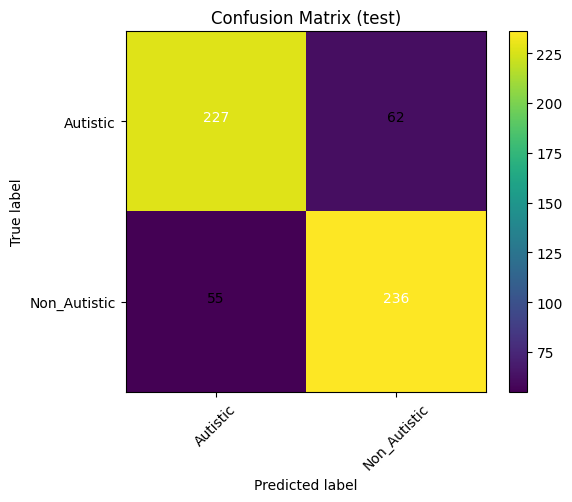

Classification report:
               precision    recall  f1-score   support

    Autistic       0.80      0.79      0.80       289
Non_Autistic       0.79      0.81      0.80       291

    accuracy                           0.80       580
   macro avg       0.80      0.80      0.80       580
weighted avg       0.80      0.80      0.80       580

Class Autistic: precision=0.8050, recall=0.7855, f1=0.7951, support=289
Class Non_Autistic: precision=0.7919, recall=0.8110, f1=0.8014, support=291
Overall accuracy: 0.7983


In [10]:
# Load the best fold model and evaluate on held-out test set

best_ckpt = ckpt_paths[best_fold_idx]
print("Loading best model from:", best_ckpt)
best_model = tf.keras.models.load_model(best_ckpt)

# Show summary of the loaded model
print("\n--- Loaded model summary ---")
best_model.summary()

# Prepare test generator (shuffle=False to preserve order)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_gen = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col="image_path",
    y_col="labels",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="binary" if is_binary else "categorical",
    shuffle=False
)

# Evaluate on test set (loss & acc)
test_eval = best_model.evaluate(test_gen, verbose=1)
print(f"Test loss/acc (best fold model): {test_eval}")

# Predictions on test set (get probabilities then map to class indices)
y_true_labels = test_df['labels'].values  # strings, same order as generator (shuffle=False)
if is_binary:
    y_proba = best_model.predict(test_gen, verbose=1).ravel()
    y_pred_idx = (y_proba >= 0.5).astype(int)
    class_indices = test_gen.class_indices
    inv_class_indices = {v:k for k,v in class_indices.items()}
    y_pred_labels = [inv_class_indices[int(i)] for i in y_pred_idx]
    y_true_idx = np.array([class_indices[l] for l in y_true_labels])
else:
    y_proba = best_model.predict(test_gen, verbose=1)
    y_pred_idx = np.argmax(y_proba, axis=1)
    class_indices = test_gen.class_indices
    inv_class_indices = {v:k for k,v in class_indices.items()}
    y_pred_labels = [inv_class_indices[int(i)] for i in y_pred_idx]
    y_true_idx = np.array([class_indices[l] for l in y_true_labels])

# Confusion matrix
cm = confusion_matrix(y_true_idx, y_pred_idx)
print("Confusion matrix (rows=true, cols=pred):\n", cm)

plt.figure(figsize=(6,5))
plt.imshow(cm, interpolation='nearest')
plt.title('Confusion Matrix (test)')
plt.colorbar()
tick_marks = np.arange(len(class_indices))
plt.xticks(tick_marks, [inv_class_indices[i] for i in range(len(inv_class_indices))], rotation=45)
plt.yticks(tick_marks, [inv_class_indices[i] for i in range(len(inv_class_indices))])
plt.ylabel('True label')
plt.xlabel('Predicted label')
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
plt.tight_layout()
plt.show()

# Classification report
report = classification_report(y_true_idx, y_pred_idx, target_names=[inv_class_indices[i] for i in range(len(inv_class_indices))])
print("Classification report:\n", report)

prec, rec, f1, sup = precision_recall_fscore_support(y_true_idx, y_pred_idx, zero_division=0)
acc = accuracy_score(y_true_idx, y_pred_idx)
for i, lab in enumerate([inv_class_indices[i] for i in range(len(inv_class_indices))]):
    print(f"Class {lab}: precision={prec[i]:.4f}, recall={rec[i]:.4f}, f1={f1[i]:.4f}, support={sup[i]}")

print(f"Overall accuracy: {acc:.4f}")
